## Calculate ARI between clustering with different paramteres and pathologist annotations

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import os

In [22]:
experiment_folder = '../../../data/breast_test/'
adata_name = "adata_1k_highly_variable.h5ad" 
title = None

In [40]:
save_dir = '../../results/ARI/test/'
os.makedirs(save_dir, exist_ok=True)

### Data preparation

In [29]:
adata = sc.read(experiment_folder + adata_name)

pathologist_annotations = pd.read_csv(experiment_folder + 'PathologistAnnotations.csv', index_col=0)


In [23]:
sample_name = list(adata.uns['spatial'].keys())[0]
if title is None:
    title = sample_name

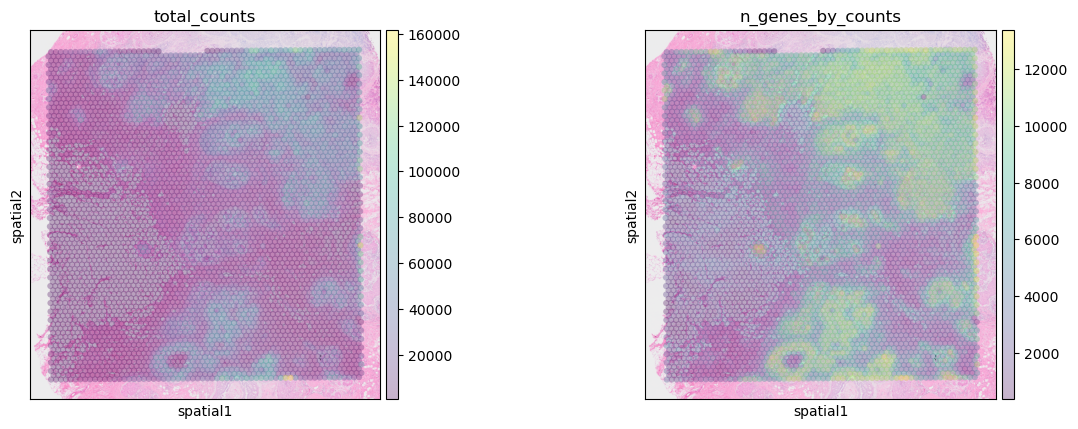

In [30]:
# finding common indices between adata and pathologist annotations
# This is necessary because the pathologist_annotations may not contain all the indices present in adata (overloaded spots, multiple run on SpaceRanger etc)

commoon_idx = pathologist_annotations.index.intersection(adata.obs.index)
adata = adata[commoon_idx].copy()
adata.obs['Pathologist Annotations'] = pathologist_annotations.loc[commoon_idx, 'Pathologist Annotations']

# For harmony-interated data, sample name should be provided in the library_id argument
# sc.pl.spatial(adata, img_key="hires", color=["total_counts","n_genes_by_counts"], size=1.8, cmap='viridis', alpha=0.3, library_id=sample_name)

sc.pl.spatial(adata, img_key="hires", color=["total_counts","n_genes_by_counts"], size=1.8, cmap='viridis', alpha=0.3)


### PCA-Neighbors-UMAP

In [31]:

print('Calculating PCA')
sc.pp.pca(adata, mask_var='highly_variable')
print('Done calculating PCA')
print('Done calculating neighbors')
sc.pp.neighbors(adata)
print('Done calculating neighbors')
print('Calculating UMAP')
sc.tl.umap(adata)
print('Done calculating UMAP')

Calculating PCA
Done calculating PCA
Done calculating neighbors
Done calculating neighbors
Calculating UMAP
Done calculating UMAP


### Leiden clustering

In [32]:
cls = []
resolutions_to_test = [1.0, 0.8, 0.7, 0.5, 0.3]
for resolution in resolutions_to_test:
    print(f'Clustering at resolution {resolution}')
    sc.tl.leiden(adata, resolution=resolution, key_added=f'leiden_{resolution}', n_iterations=2)
    cls.append(f"leiden_{resolution}")


Clustering at resolution 1.0
Clustering at resolution 0.8
Clustering at resolution 0.7
Clustering at resolution 0.5
Clustering at resolution 0.3


### ARI calculation

In [33]:
annotations = adata.obs['Pathologist Annotations']
print("Total number of unique annotations: ", len(annotations.unique()))

for resolution in resolutions_to_test:
    clustering = adata.obs[f'leiden_{resolution}']
    print(f'ARI for resolution {resolution}: {adjusted_rand_score(annotations, clustering)}')
    print(f'Number of clusters for resolution {resolution}: {len(clustering.unique())}')


Total number of unique annotations:  11
ARI for resolution 1.0: 0.36475646125605565
Number of clusters for resolution 1.0: 17
ARI for resolution 0.8: 0.4185437805059831
Number of clusters for resolution 0.8: 15
ARI for resolution 0.7: 0.49021693091917273
Number of clusters for resolution 0.7: 14
ARI for resolution 0.5: 0.4778795139160364
Number of clusters for resolution 0.5: 9
ARI for resolution 0.3: 0.4361248176896005
Number of clusters for resolution 0.3: 8


### Visualisation

leiden_1.0
leiden_0.8
leiden_0.7
leiden_0.5
leiden_0.3


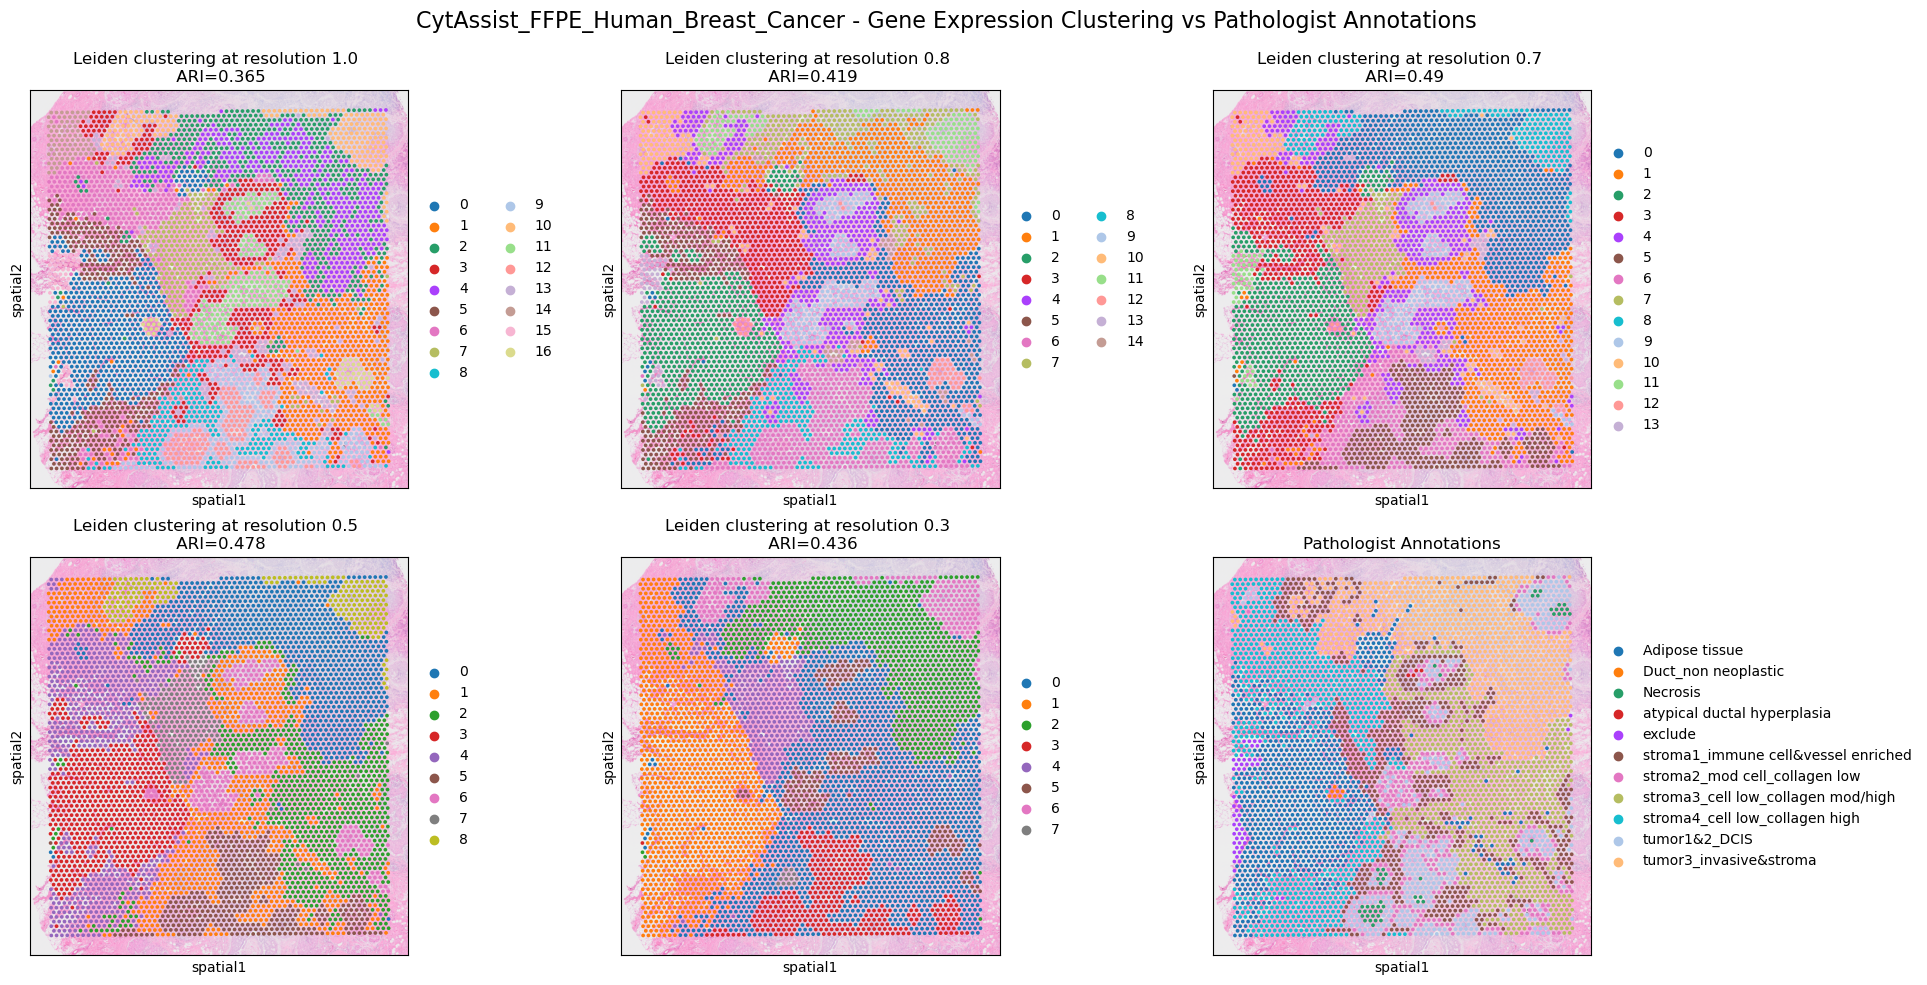

In [41]:
# Define the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()

# Plot clustering results
for i, key in enumerate(cls):
    print(key)
    library_id = sample_name
    clustering = adata.obs[key]
    ari = adjusted_rand_score(annotations, clustering)

    sc.pl.spatial(
        adata, 
        color=key, 
        ax=axs[i], 
        title=f'Leiden clustering at resolution {float(key.split("_")[1])} \n ARI={np.round(ari, 3)}',
        library_id=library_id, 
        show=False
    )

# Plot pathologist annotations
sc.pl.spatial(
    adata, 
    color='Pathologist Annotations', 
    ax=axs[-1], 
    title='Pathologist Annotations', 
    library_id=library_id, 
    show=False
)

# Adjust subplot spacing and layout
plt.subplots_adjust(wspace=0.4, left=0.05, right=0.95, top=0.9, bottom=0.05)
plt.tight_layout()

# Set figure title
plt.suptitle(f'{title} - Gene Expression Clustering vs Pathologist Annotations', fontsize=16)
# spece for title
plt.subplots_adjust(top=0.9)
# Save the plot
plt.savefig(f"{save_dir}/{sample_name}_clustering.png")

# Display the plot
plt.show()

In [42]:
print(f"Plots saved to {save_dir}/{sample_name}_clustering.png")

Plots saved to ../../results/ARI/test//CytAssist_FFPE_Human_Breast_Cancer_clustering.png
